In [2]:
import torch
import numpy as np
import random
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print("device:", device)

device: mps


In [3]:
# Preprocess data

edge = torch.load("./Cora/edge.pt")
edge = torch.transpose(edge, 0, 1)

feat = torch.load("./Cora/feat.pt").type(torch.float32)

label = torch.load("./Cora/label.pt")

degree = torch.from_numpy(np.bincount(edge[:, 0]))

feat = feat.to(device)
degree = degree.to(device)
edge = edge.to(device)


print(f"# Nodes: {feat.shape[0]}")
print(f"# Edges: {edge.shape[0]}")

num_nodes, dim_feat = feat.shape
num_label = max(label) + 1
dim_hidden = 128

adj = torch.zeros((num_nodes, num_nodes), device=device)
print(edge)
for i, j in edge:
    adj[i, j] += 1

# Nodes: 2708
# Edges: 10556
tensor([[   0,  633],
        [   0, 1862],
        [   0, 2582],
        ...,
        [2707,  598],
        [2707, 1473],
        [2707, 2706]], device='mps:0')


In [5]:
class GraphSageLayer(nn.Module):

    def __init__(self, dim_in: int, dim_out: int):
        super(GraphSageLayer, self).__init__()

        self.dim_in = dim_in
        self.dim_out = dim_out
        self.act = nn.ReLU()

        self.weight = nn.Parameter(data=torch.zeros((dim_in, dim_out), device=device), requires_grad=False)
        nn.init.xavier_uniform_(self.weight)

    def forward(self, feat: torch.Tensor,
                adjacency: torch.Tensor,
                activate: bool) -> torch.Tensor:
        
        adj_eye = adjacency + torch.eye(num_nodes, device=device)
        degree = torch.sum(adj_eye, dim=1)
        dgr_inv = torch.diag(1/degree)
        
        laplace_sym = dgr_inv @ adj_eye
        out = laplace_sym @ feat
        if activate:
            out = self.act(out)
        
        return out
    
class GraphSage(nn.Module):

    def __init__(self, num_layers: int,
                 dim_in: int,
                 dim_hidden: int,
                 dim_out: int):

        super(GraphSage, self).__init__()

        self.num_layers = num_layers
        self.dim_in = dim_in
        self.dim_hidden = dim_hidden
        self.dim_out = dim_out

        self.layers = nn.ModuleList()
        for l in range(num_layers):
            self.layers.append(GraphSageLayer(self.dim_in if l == 0 else self.dim_hidden, self.dim_hidden if l < num_layers-1 else self.dim_out))


    def forward(self, feat: torch.Tensor,
                adj: torch.Tensor) -> torch.Tensor:

        x_in = feat
        for layer in self.layers:
            x_out = layer(x_in, adj, (False if self.layers[-1] == layer else True))
            x_in = x_out

        return x_out
    
    def forward_k_layer(self, feat: torch.Tensor,
                        adj: torch.Tensor,
                        k: int) -> torch.Tensor:
        
        x_in = feat
        for i, layer in enumerate(self.layers):
            if i >= k:
                break
            x_out = layer(x_in, adj, i < k-1)
            x_in = x_out
            
        return x_out


100%|██████████| 10/10 [00:02<00:00,  3.40it/s]


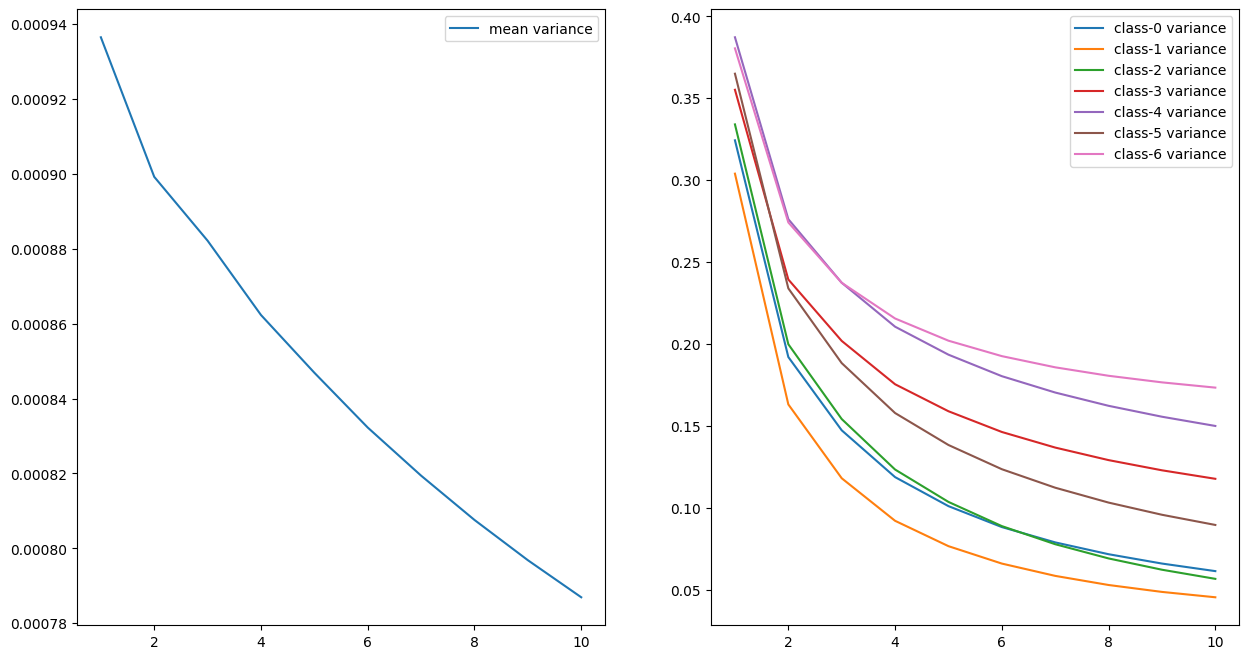

In [16]:
LAYERS = list(range(1, 11))

dim_in = feat.shape[1]
dim_hidden = 700
dim_out = 700
SEED = 42

torch.manual_seed(SEED)

model = GraphSage(max(LAYERS), dim_in, dim_hidden, dim_out)
model.eval()

mean_variace = []
variance = [[] for _ in range(7)]

for num_layer in tqdm(LAYERS):

    feature_matrix = model.forward_k_layer(feat, adj, num_layer)
    embedding = feature_matrix
    
    mean_vec = torch.stack([torch.mean(embedding[label == l], axis=0) for l in range(0, 7)])
    mean_variace.append(torch.norm(torch.var(mean_vec), p=2).item())
    
    for l in range(0, 7):
        variance[l].append(torch.norm(torch.var(embedding[label == l], axis=0), p=2).item())
    


fig, axes = plt.subplots(1, 2, figsize=(15, 8))
axes[0].plot(LAYERS, mean_variace, label="mean variance")
for l in range(0, 7):
    axes[1].plot(LAYERS, variance[l], label=f"class-{l} variance")
axes[0].legend()
axes[1].legend()
plt.show()